# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Описание проекта:**

Заказчик этого исследования — сеть отелей «Как в гостях». 

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.


**Цель проекта:**

Необходимо разработать систему, которая будет предсказывает отказ от брони.

**Метод работы модели:**

Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.


**Дополнительная информация:**

Основная бизнес-метрика —  прибыль. 
В данном случае прибыль - это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. (Количество раз, когда убираются - расчётное значение). 

Стоимость номеров отеля:

    •	Категория A: за ночь — 1 000, разовое обслуживание — 400;
    •	Категория B: за ночь — 800, разовое обслуживание — 350;
    •	Категория C: за ночь — 600, разовое обслуживание — 350;
    •	Категория D: за ночь — 550, разовое обслуживание — 150;
    •	Категория E: за ночь — 500, разовое обслуживание — 150;
    •	Категория F: за ночь — 450, разовое обслуживание — 150;
    •	Категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

Затраты на разработку (400.000 руб.) должны быть меньше той выручки, которую система принесёт компании.


In [3]:
# работа с данными:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy.random import RandomState
import random

# предобработка:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# модели для обучения:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression


# метрики:
from sklearn.metrics import make_scorer, recall_score

import os
# дополнительно:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
os.chdir(r'C:\Users\Grine\Desktop\GitHub\YandexPracticum\7 СБОРНЫЙ ПРОЕКТ 2\\')
state = RandomState(12345) 

### Загрузка данных

In [5]:
data = pd.read_csv('hotel_train.csv')
data_test = pd.read_csv('hotel_test.csv')

### Шаг 2. Предобработка и исследовательский анализ данных

#### Предобработка

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [8]:
data.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [9]:
data_test.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


**Выводы по предобработка:**

Нет необходимости в том, чтобы изменяться форматы или типы данных ни в обучающей, ни в тестовой выборках.
Однако, можно уменьшить все значения с 64-битной системы до 32-битной c целью экономии оперативной памяти. 

На первый взгляд видна незначительаня разница между обучающими и тестовыми данными. Тем не менее необходимо будет провести разведочный анализ данных.

In [10]:
# для обучающих данных
int_columns = data.select_dtypes(include='int64').columns
data[int_columns] = data[int_columns].astype('int32')

float_columns = data.select_dtypes(include='float64').columns
data[float_columns] = data[float_columns].astype('float32')


# для тестовых данных
int_columns_test = data_test.select_dtypes(include='int64').columns
data_test[int_columns_test] = data_test[int_columns_test].astype('int32')

float_columns_test = data_test.select_dtypes(include='float64').columns
data_test[float_columns_test] = data_test[float_columns_test].astype('float32')

#### Исследовательский  анализ данных

**Количественные признаки:**

In [11]:
# Методом describe изучим данные для тестовой и обучающей выборок, сравним их.
test_describe = data_test.describe().reset_index().reset_index() 
test_describe['type'] = 'тест'
data_describe = data.describe().reset_index().reset_index()
data_describe['type']= 'обучение'
pd.concat([test_describe, data_describe]).sort_values(by='level_0').drop(['level_0', 'id', 'is_canceled'], axis=1).iloc[2:]

,index,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,type
1,mean,97.587868,2017.000000,17.804054,15.656948,0.867888,2.340090,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979,тест
1,mean,96.337914,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978,обучение
2,std,86.506012,0.000000,9.177384,8.766429,0.853394,1.375170,0.489370,0.343488,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683,тест
2,std,96.126114,0.449481,13.464024,8.748182,0.853477,1.354992,0.480201,0.334093,0.098816,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108,обучение
3,min,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,тест
3,min,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,обучение
4,25%,23.000000,2017.000000,10.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,тест
4,25%,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,обучение
5,50%,76.000000,2017.000000,18.000000,15.500000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,тест
5,50%,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,обучение


Выделим поля, в которых значения тестовых данных и обучающихся значительно отличается:

    1) Cильное расхождение наблюдается в отменённых заказах у клиента поле (previous_cancellations);
    2) Сильное расхождение по стандартному отклонению наблюдается в поле (days_in_waiting_list) - сколько дней заказ ожидал подтверждения;
    3) Стоит изучить заказы без взрослых.

При этом, наблюдается перевес нулевых значений. в следующих полях: 
    
    1) 'children'
    2) 'is_repeated_guest'
    3) 'previous_cancellations'
    4) 'previous_bookings_not_canceled'
    5) 'booking_changes'
    6) 'days_in_waiting_list'
    7) 'required_car_parking_spaces'
    8) 'total_of_special_requests'

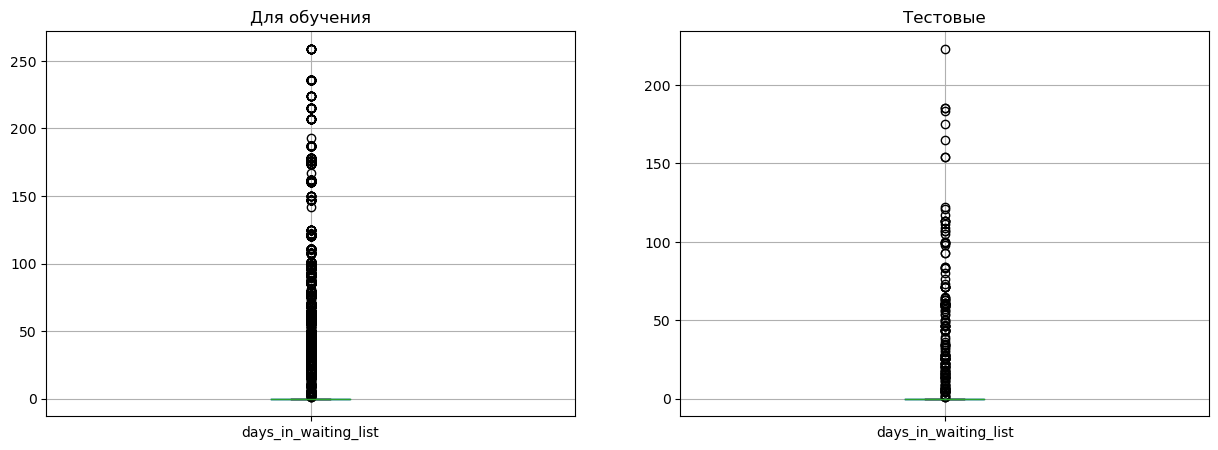

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
data.boxplot(column='days_in_waiting_list')
plt.title('Для обучения')

plt.subplot(1, 2, 2)
data_test.boxplot(column='days_in_waiting_list')
plt.title('Тестовые')

plt.show()

*От выбросов точно стоит избавиться (а лучше заполнить их средним значением), но для начала нужно проверить гипотезу, не бывает ли такого, что "количество дней между датой бронирования и датой прибытия" меньше, чем "количество дней, когда заказ ожидал подтверждения".
Дополнительно изучим этот параметр:*

In [13]:
data_tech = data[['days_in_waiting_list', 'lead_time', 'is_canceled']]
print('Данные для обучения:')
display(data_tech[data_tech['lead_time'] < data_tech['days_in_waiting_list']])

print('Данные для теста:')
data_tech = data_test[['days_in_waiting_list', 'lead_time', 'is_canceled']]
display(data_tech[data_tech['lead_time'] < data_tech['days_in_waiting_list']])

Данные для обучения:


,days_in_waiting_list,lead_time,is_canceled


Данные для теста:


,days_in_waiting_list,lead_time,is_canceled


*Не бывает такого, что клиент ждёт подтверждения брони дольше, чем время до заказа. Это избавляет нас от очевидных выбросов.*

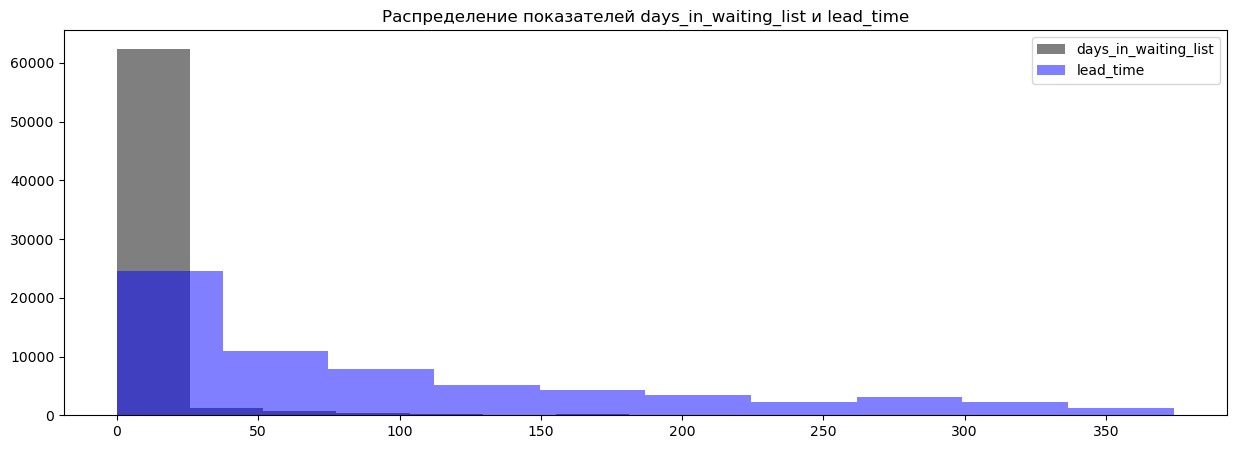

In [15]:
x_array = data['days_in_waiting_list'].values
x2_array = data['lead_time'].values

plt.figure(figsize=(15, 5))
plt.hist(x_array, color='black', alpha = 0.5, label='days_in_waiting_list')

plt.hist(x2_array, color='b', alpha = 0.5, label='lead_time')
plt.legend()

plt.title('Распределение показателей days_in_waiting_list и lead_time')
plt.show()

*Распределение является случайным и не может быть заменено каким-то из значений. Несмотря на наличие выбросов - оставим как есть.*

In [16]:
# дополнительно очистим данные от заказов, когда взрослые отсуствуют
data = data[data['adults'] != 0]
data_test = data_test[data_test['adults'] != 0]

Далее изучим столбцы, средние значения в которых нулевые.

Данные для тестирования:

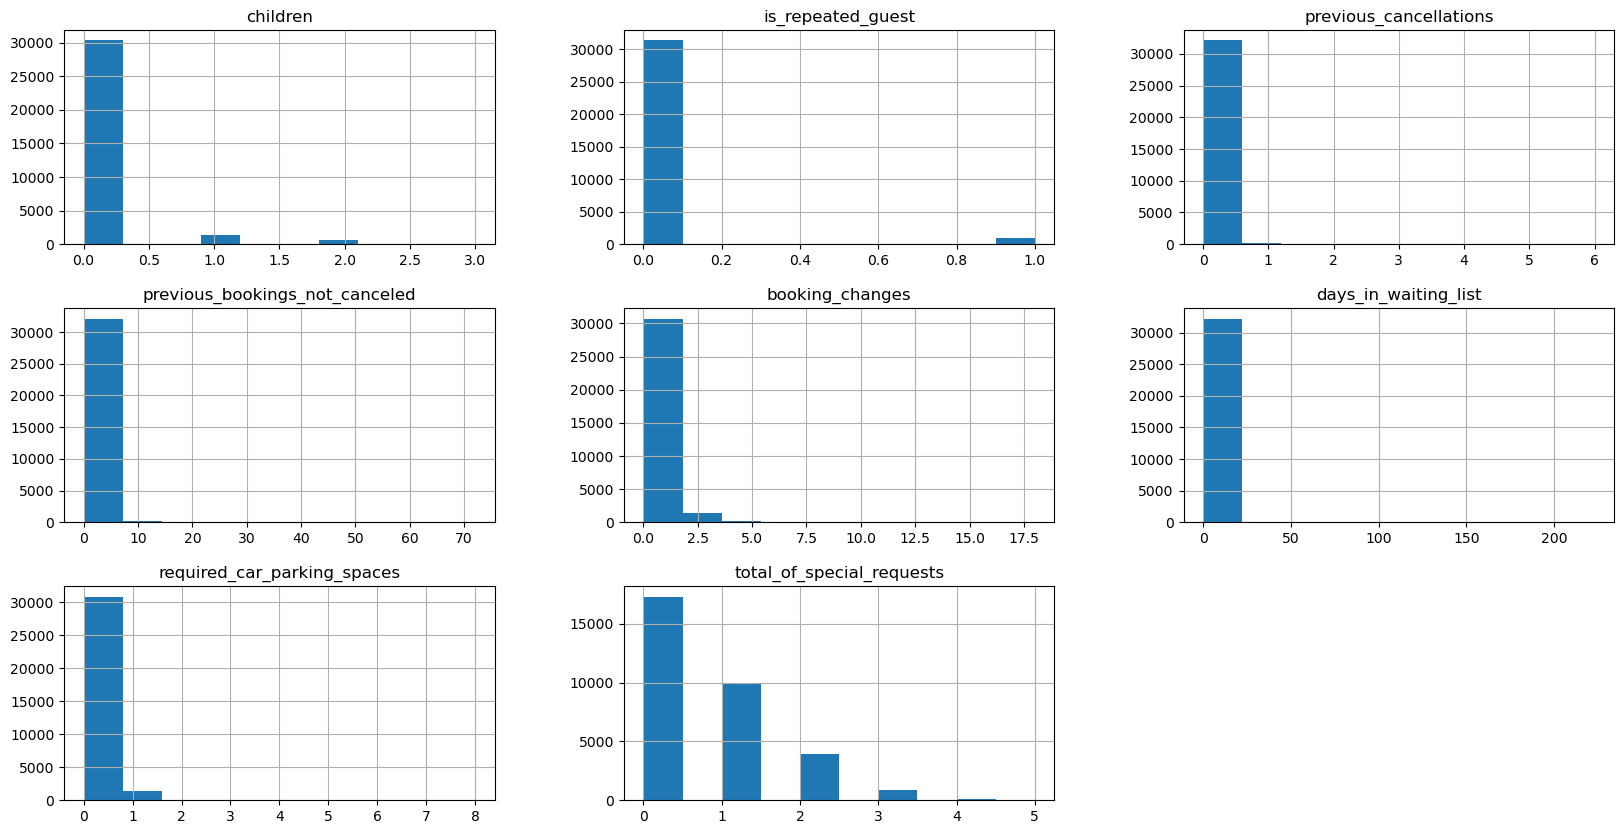

In [17]:
data_test[['children', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']].hist(figsize=(20, 10));

**В данных очень много пропусков. Перепроверим их.**

In [18]:
data_test['children'].value_counts()

0.0    30353
1.0     1392
2.0      595
3.0        3
Name: children, dtype: int64

*По количеству детей - всё в порядке. Этот признак оставим как есть. Несмотря на то, что присуствует не так много записей, где люди едут с 3 детьми, тем не менее, такое бывает.*

In [19]:
data_test['previous_cancellations'].value_counts()

0    32118
1      164
2       29
6       15
4       10
3        6
5        1
Name: previous_cancellations, dtype: int64

*количество отменённых заказов у клиента - это важный параметр и абсолютно случайный. Преобразовать его не получится.*

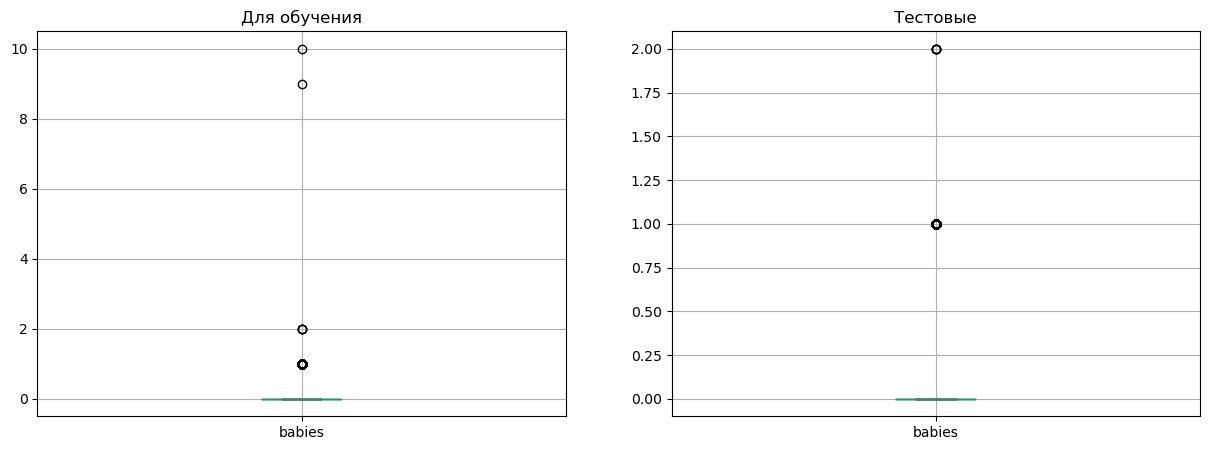

In [21]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
data.boxplot(column='babies')
plt.title('Для обучения')

plt.subplot(1, 2, 2)
data_test.boxplot(column='babies')
plt.title('Тестовые')

plt.show()

**В данных по количеству младенцев явно есть выбросы. Предлагается избавится от тех значений, когда малышей больше, чем 2.**

In [22]:
data = data.query('babies <= 2')
data_test = data_test.query('babies <= 2')

total_nights — это сумма stays_in_week_nights и stays_in_weekend_nights,  проверим так ли это.

In [23]:
def count_of_nights(data):
    if data['total_nights'] == data['stays_in_weekend_nights'] + data['stays_in_week_nights']:
        return 'стоит удалить лишние признаки'
    else:
        return 'стоит оставить признаки'
    
data['тестовая колонка'] = data.apply(count_of_nights, axis=1)
print(data['тестовая колонка'].value_counts())
data_test['тестовая колонка'] = data_test.apply(count_of_nights, axis=1)
print(data_test['тестовая колонка'].value_counts())

стоит удалить лишние признаки    65061
Name: тестовая колонка, dtype: int64
стоит удалить лишние признаки    32343
Name: тестовая колонка, dtype: int64


**Да это так. Соответственно от этих двух столбцов можно избавиться.**

In [24]:
data = data.drop(['stays_in_weekend_nights', 'stays_in_week_nights', 'тестовая колонка'], axis=1)
data_test = data_test.drop(['stays_in_weekend_nights', 'stays_in_week_nights', 'тестовая колонка'], axis=1)

Изучим корреляции признаков:

In [25]:
#Посмотрим, как коррелирует целевой признак, с остальными:

# создадим 2 матрицы корреляций, и выделим целевой признак. Транспортируем таблицы, для удобного анализа
data_corr = data.corr().iloc[1:2, 1:].transpose()
data_test_corr = data_test.corr().iloc[1:2, 1:].transpose()
# соединим созданные признаки
data_and_data_test_corr = pd.concat([data_corr, data_test_corr], axis=1).reset_index()

# перемименуем названия столбцов, для более понятных признаков
data_and_data_test_corr.columns=['feature', 'data_is_canceled_feature', 'data_test_is_canceled_feature']

# изучим разницу между признаками и отранжируем по убыванию разницы. Чтобы удобно было увидеть зависимость данных.
data_and_data_test_corr['corr_difference'] = abs(data_and_data_test_corr['data_is_canceled_feature']-data_and_data_test_corr['data_test_is_canceled_feature'])
data_and_data_test_corr.sort_values(by='corr_difference', ascending=False)

,feature,data_is_canceled_feature,data_test_is_canceled_feature,corr_difference
9,previous_cancellations,0.153126,-0.032892,0.186019
1,lead_time,0.328596,0.238382,0.090215
8,is_repeated_guest,-0.040303,-0.125593,0.085289
12,days_in_waiting_list,0.075859,0.018397,0.057462
14,total_of_special_requests,-0.257134,-0.218440,0.038694
5,adults,0.044418,0.079475,0.035057
15,total_nights,0.001339,0.036173,0.034833
6,children,-0.017193,0.010626,0.027819
3,arrival_date_week_number,0.012751,0.037554,0.024803
10,previous_bookings_not_canceled,-0.045638,-0.065408,0.019771


**previous_cancellations - признак, который сильнее всего влияет на статистику.**

In [26]:
# дополнительно удалим client_id - этот признак, тоже не повлияет на обучение модели.
data = data.drop(['id'], axis=1)
data_test = data_test.drop(['id'], axis=1)

In [27]:
data = data.drop_duplicates()
data_test = data_test.drop_duplicates()

Изучим категориальные переменные:

In [28]:
data_train_obj_columns = data.select_dtypes('object').columns

for mean in data_train_obj_columns:
    x_array = set(data[mean])
    y_array = set(data_test[mean])
    print('Данные для обучения:', set(x_array),'|', 'Данные для тестирования:', set(y_array))
    
    print(f'Множества столбцов {mean} и равны:', np.array_equal(x_array, y_array), '\n'*2)

Данные для обучения: {'August', 'May', 'October', 'September', 'November', 'December', 'February', 'March', 'July', 'June', 'January', 'April'} | Данные для тестирования: {'August', 'May', 'February', 'June', 'March', 'July', 'January', 'April'}
Множества столбцов arrival_date_month и равны: False 


Данные для обучения: {'FB       ', 'BB       ', 'HB       ', 'SC', 'SC       '} | Данные для тестирования: {'FB       ', 'BB       ', 'HB       ', 'SC', 'SC       '}
Множества столбцов meal и равны: True 


Данные для обучения: {'STP', 'ISR', 'LBN', 'AUT', 'ATA', 'PRI', 'KAZ', 'KEN', 'JPN', 'MLI', 'COL', 'ECU', 'TZA', 'PLW', 'SVK', 'VNM', 'JAM', 'DZA', 'CYP', 'MYS', 'BGD', 'ZMB', 'NGA', 'ROU', 'SUR', 'ARG', 'BOL', 'FIN', 'UZB', 'USA', 'DNK', 'MEX', 'NAM', 'LBY', 'TJK', 'BHR', 'HRV', 'DOM', 'ZAF', 'BWA', 'DMA', 'ESP', 'NLD', 'ARM', 'ARE', 'EGY', 'DEU', 'LCA', 'AGO', 'CHN', 'GLP', 'BFA', 'ZWE', 'PAN', 'ISL', 'VEN', 'PYF', 'MDV', 'FRA', 'AUS', 'BIH', 'GAB', 'OMN', 'TUR', 'GGY', 'ETH', 'KHM', 

Категориальные признаки отличаются друг от друга в столбцах "arrival_date_month" и "country".
 
Поскольку столбец "arrival_date_month" в данных для обучения - содержит информацию за полный год (а точнее, за несколько), а тестовые данные хранят информацию за пол года. Тем не менее - это не помешает обучаться модели. А вот столбец "country" - требует дополнительного исследования.

Но перед этим избавимся от очевидных неявных дубликатов в столбцах: meal и reserved_room_type. 

In [29]:
data['reserved_room_type'] = data['reserved_room_type'].str.strip()           # избавимся от пробелов
data_test['reserved_room_type'] = data_test['reserved_room_type'].str.strip() # избавимся от пробелов

data['meal'] = data['meal'].str.strip()
data_test['meal'] = data_test['meal'].str.strip()

###  Формулировка ML-задачи на основе бизнес-задачи

#### Создадим все столбцы, необходимые для оценки прибыли.

In [30]:
# первое, что нужно сделать - это создать все необходимые поля для расчёта выручки
def price(x):
    '''
    Функция рассчитывает стоимость номера исходя из его типа
    '''
    if x == 'A':
        return 1000
    elif x == 'B':
        return 800
    elif x == 'C':
        return 600
    elif x == 'D':
        return 550 
    elif x == 'E':
        return 500
    elif x == 'F':
        return 450
    elif x == 'G':
        return 350
    
def cleaning_price(x):
    '''
    Функция рассчитывает стоимость разовой уборки номера исходя из его типа
    '''
    if x == 'A':
        return 400
    elif x in ['B', 'C']:
        return 350
    else: 
        return 150
    
def cleaning_counts(x):
    '''
    Функция рассчитывает количество уборок
    '''
    return (1 + floor(x / 2))

def seasone_coef(x):
    '''
    Функция рассчитывает сезонный коеф.
    '''
    if x in ['June', 'July', 'August']:
        return 1.4
    elif x in ['December', 'January', 'February']:
        return 1
    else:
        return 1.2

In [31]:
data['room_price'] = data.reserved_room_type.apply(lambda x: price(x))
data_test['room_price'] = data_test.reserved_room_type.apply(lambda x: price(x))

data['cleaning_price'] = data.reserved_room_type.apply(lambda x1: cleaning_price(x1))
data_test['cleaning_price'] = data_test.reserved_room_type.apply(lambda x1: cleaning_price(x1))

data['cleaning_counts'] = data.total_nights.apply(lambda x2: cleaning_counts(x2))
data_test['cleaning_counts'] = data_test.total_nights.apply(lambda x2: cleaning_counts(x2))

data['seasone_coef'] = data.arrival_date_month.apply(lambda x3: seasone_coef(x3))
data_test['seasone_coef'] = data_test.arrival_date_month.apply(lambda x3: seasone_coef(x3))

In [32]:
def total_revenue(df):
    '''
    Функция расчитывает общую выручку. Если клиент отказался от бронирования, то она отрицательна.
    '''
    if df['is_canceled'] == 0:
        return (df['room_price'] * df['seasone_coef'] * df['total_nights'] - df['cleaning_counts'] * df['cleaning_price'])
    else:
        return -(df['room_price'] * df['seasone_coef'] + df['cleaning_price'])

data['total_revenue'] = data.apply(total_revenue, axis=1)
data_test['total_revenue'] = data_test.apply(total_revenue, axis=1)

#### Проанализируем целевую бизнес-метрику.

In [33]:
def month_converter(month):
    '''
    Функция определяет номер месяца.
    '''
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return months.index(month[:3]) + 1


def profit_statistics(data, year):
    '''
    Функция представляет сводную статистику о том, как изменяется выручка по месяцам
    '''
    data = data.query('arrival_date_year == @year')
    data_total_revenue_per_month = (data
                                    .pivot_table(index='arrival_date_month',
                                                 columns='is_canceled',
                                                 values='total_revenue',
                                                 aggfunc='sum')
                                    .reset_index()) # создадим свод
    # переименуем столбцы
    data_total_revenue_per_month.columns = ['month', 'earned', 'losed'] 



    # отсортируем дата-фрейм по номеру месяца
    data_total_revenue_per_month['month_number'] = data_total_revenue_per_month.month.apply(lambda x: month_converter(x))
    data_total_revenue_per_month = data_total_revenue_per_month.sort_values(by='month_number')

    # создадим переменные для графиков
    x = data_total_revenue_per_month['month']
    y1 = abs(data_total_revenue_per_month['losed']/1000000)
    y2 = data_total_revenue_per_month['earned']/1000000

    # создадим и оформим график
    plt.figure(figsize=(15, 5))

    plt.plot(x, y1, color='green', marker='o')

    for i, mean in enumerate(y1):
        plt.text(i, mean+0.3, round(float(mean), 2), ha='center')

    plt.bar(x, y2, color='lightblue')

    for i, mean in enumerate(y2):
        plt.text(i, mean, round(float(mean), 2), ha='center')

    plt.title('Выручка и убытки в млн. руб, по месяцам. Данные для обучения')
    plt.ylabel('Млн. руб')
    plt.xlabel('Месяц')
    plt.legend(['Убытки', 'Выручка'])

    plt.show()


    data_total_revenue_per_month['profit'] = data_total_revenue_per_month['earned'] + data_total_revenue_per_month['losed']
    print('Общая вырчука за исследуемый период:', round(sum(data_total_revenue_per_month['earned']/1_000_000), 2), 'в млн. руб.')
    print('Общая прибыль за исследуемый период:', round(sum(data_total_revenue_per_month['profit']/1_000_000), 2), 'в млн. руб.')
    
    data_total_revenue_per_month = data_total_revenue_per_month.sort_values(by='profit')
    data_total_revenue_per_month = data_total_revenue_per_month[['profit', 'month']].transpose()
    data_total_revenue_per_month.columns = data_total_revenue_per_month.loc['month'].tolist()
    data_total_revenue_per_month = data_total_revenue_per_month.drop('month', axis=0)
    return display(data_total_revenue_per_month)

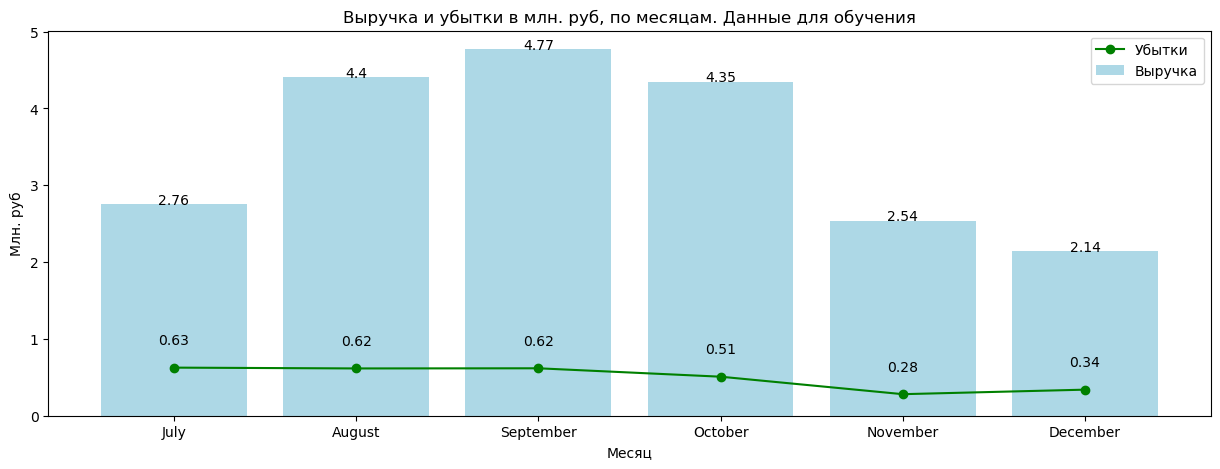

Общая вырчука за исследуемый период: 20.96 в млн. руб.
Общая прибыль за исследуемый период: 17.98 в млн. руб.


,December,July,November,August,October,September
profit,1804850.0,2132150.0,2258820.0,3787050.0,3839900.0,4154640.0


In [34]:
profit_statistics(data, year=2015)

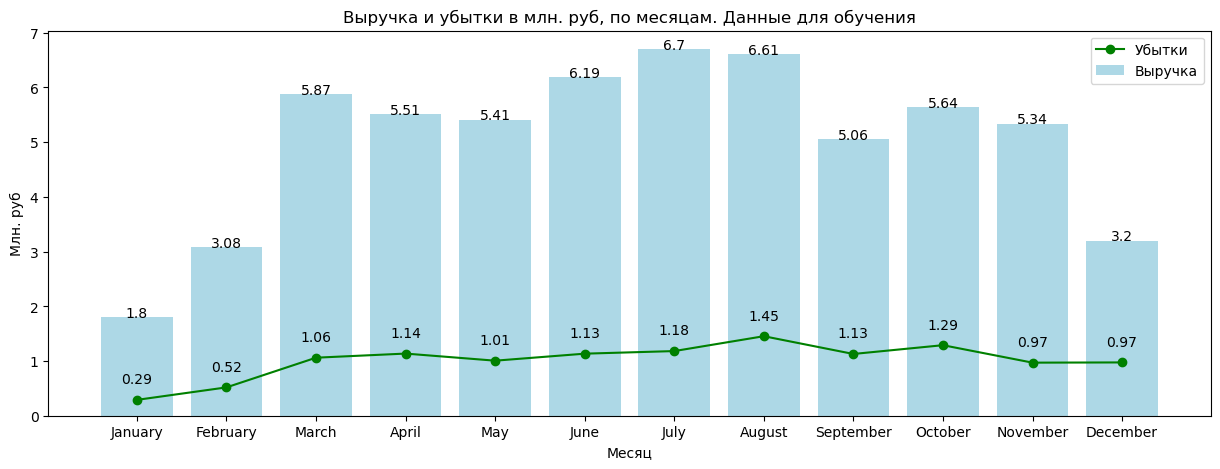

Общая вырчука за исследуемый период: 60.4 в млн. руб.
Общая прибыль за исследуемый период: 48.27 в млн. руб.


,January,December,February,September,October,November,April,May,March,June,August,July
profit,1508800.0,2225850.0,2560200.0,3929830.0,4351050.0,4367760.0,4374060.0,4404220.0,4813660.0,5056100.0,5157970.0,5517260.0


In [35]:
profit_statistics(data, year=2016)

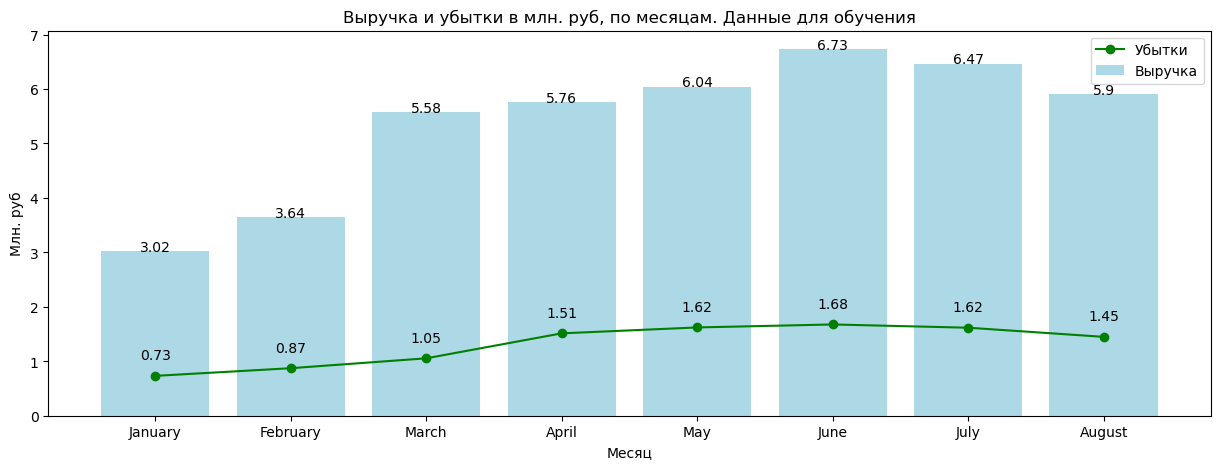

Общая вырчука за исследуемый период: 43.14 в млн. руб.
Общая прибыль за исследуемый период: 32.61 в млн. руб.


,January,February,April,May,August,March,July,June
profit,2285100.0,2769500.0,4246690.0,4421240.0,4454480.0,4523200.0,4849620.0,5057780.0


In [36]:
profit_statistics(data_test, year=2017)

Исходя из данных выше видно, что у отеля всё неплохо с выручкой. Однако, есть значимая доля убытков. Находящаясь примерно на 5-10% от общей выручки отеля.

Поэтому, прибыль можно максимизировать. Сделать это можно за счёт ML-алгоритмов, один из которых будет рассмотрен дальше.

In [37]:
# после исследования данных, ненужные для обучения столбцы также можно удалить.
data = data.drop(['arrival_date_year', 'arrival_date_month'], axis=1) 
data_test = data_test.drop(['arrival_date_year', 'arrival_date_month'], axis=1) 

data = data.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

### Разработка модели ML

#### Выбор и обоснование метрики

Поскольку для нас самое важное - это найти тех клиентов, кто наиболее точно откажется от брони. То больше всего подходит метрика recall. 

Всё дело в том, что в самом задание недостаточно информации. Мы не понимаем, как измениться выручка для тех клиентов, которые не будут отменять бронь номера, но внесли депозит. В связи с этим нам нужно минимизировать количество таких клиентов. 

 #### Обучение моделей и предобработка:

In [38]:
# выделим дополнительные дата-фреймы, на которых будем проводить предобработку для обучения.
df = data.copy()
df_test = data_test.copy()

# выделим признаки
target = df['is_canceled']
features = df.drop('is_canceled', axis=1).iloc[:, :-5]

target_test = df_test['is_canceled']
features_test = df_test.drop('is_canceled', axis=1).iloc[:, :-5]

In [39]:
num_cols = selector(dtype_exclude=[object, bool]) # опредлим числовые объекты
cat_cols = selector(dtype_include=object)         # опредлим категориальные объекты

# Методы предобработки:
categorical_preprocessor_log = OneHotEncoder(handle_unknown='ignore')
categorical_preprocessor_tree = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan) 
numerical_preprocessor = StandardScaler()

# создадим этап предобработки для логистической регрессии
preprocessor_log = ColumnTransformer([
    ('oe', categorical_preprocessor_log, cat_cols),
    ('scaler', numerical_preprocessor, num_cols)])

# создадим этап предобработки для случайного леса
preprocessor_tree = ColumnTransformer([
    ('ohe', categorical_preprocessor_tree, cat_cols),
    ('scaler', numerical_preprocessor, num_cols)])

In [40]:
# предобработаем признаки
features_logs = preprocessor_log.fit_transform(features)
features_trees = preprocessor_tree.fit_transform(features)

In [41]:
dict_of_resuts_logs_models = {}

# протестим 5 случайных моделей (пока не получим 5 результатов)
for pen in ['l1', 'l2', None, 'elasticnet']:
    for solv in ['lbfgs', 'liblinear']:
        model_log = LogisticRegression(class_weight = 'balanced',
                                                   penalty=pen,
                                                   solver=solv,
                                                   random_state=12345)
                
        result_log = cross_val_score(model_log, features_trees, target, cv=5, scoring='recall')
        results_log = np.mean(result_log)
        dict_of_resuts_logs_models.update({model_log: results_log})

In [42]:
dict_of_resuts_logs_models

{LogisticRegression(class_weight='balanced', penalty='l1', random_state=12345): nan,
 LogisticRegression(class_weight='balanced', penalty='l1', random_state=12345,
                    solver='liblinear'): 0.637927927927928,
 LogisticRegression(class_weight='balanced', random_state=12345): 0.6406306306306305,
 LogisticRegression(class_weight='balanced', random_state=12345,
                    solver='liblinear'): 0.637927927927928,
 LogisticRegression(class_weight='balanced', penalty=None, random_state=12345): nan,
 LogisticRegression(class_weight='balanced', penalty=None, random_state=12345,
                    solver='liblinear'): nan,
 LogisticRegression(class_weight='balanced', penalty='elasticnet',
                    random_state=12345): nan,
 LogisticRegression(class_weight='balanced', penalty='elasticnet',
                    random_state=12345, solver='liblinear'): nan}

In [43]:
dict_of_resuts_trees_models = {}

for n_e in [50, 100, 150]:
    for depth in [5, 10, 15]:
        model_tree = RandomForestClassifier(class_weight = 'balanced', n_estimators = n_e, max_depth = depth,
                                                                             random_state=12345)
        
        results_tree = np.mean(cross_val_score(model_tree, features_trees, target, cv=5, scoring='recall'))
        dict_of_resuts_trees_models.update({model_tree: results_tree})

In [44]:
dict_of_resuts_trees_models

{RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50,
                        random_state=12345): 0.5553153153153153,
 RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                        random_state=12345): 0.45099099099099105,
 RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=50,
                        random_state=12345): 0.3524324324324325,
 RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=12345): 0.5671171171171172,
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        random_state=12345): 0.45657657657657663,
 RandomForestClassifier(class_weight='balanced', max_depth=15,
                        random_state=12345): 0.35081081081081084,
 RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=150,
                        random_state=12345): 0.5676576576576576,
 RandomForestClassifier(class_weight='balanced', max_depth=

Лучшая модель в данном случае - модель логистической регресии со следующим набором гиперпараметров:
    
    -  LogisticRegression(class_weight='balanced', penalty='l1', random_state=12345,
                    solver='liblinear')
    
Теперь применим лучшую модель к тестовой выборке выборке и оценим насколько же изменится прибыль отеля. 

#### Оценка изменения целевой метрики после внедрения модели (за 2017 год):

In [45]:
# подготовим признаки 
features_test_log = preprocessor_log.fit_transform(features_test)

In [48]:
def result_revenue_score(y_true, y_pred, **kwargs):
    '''
    Принцип работы функции:
        1) Считается выручка до внедрения модели
        2) функия оценивает индексы, по которым был действительно предсказан отказ (отбирает индексы);
        3) По индексами отбираем данные в тестовом фрейме и считает выручку с внедрения депозитов; 
        4) Далее отбираются остальные данные и считается выручка по ним
        5) Затем считается разница и вычитается себестоимость модели.
    '''

    BUDGET_FOR_MODEL = 400_000
    target_indexes = [i for i in range(len(y_pred)) if y_pred[i] == 1]
    
    model_selections_true = df_test[(df_test.index.isin(target_indexes)) & (df_test['is_canceled'] == 1)]
    
    deposite_profit = abs(sum(model_selections_true['total_revenue'])*0.8)

    other_data = df_test[~df_test.index.isin(model_selections_true.index)]
    
    revenue_before = df_test['total_revenue'].sum()
    
    revenue_after = deposite_profit + other_data['total_revenue'].sum()
    
    net_profit = abs((revenue_before - (revenue_after - BUDGET_FOR_MODEL)))
    return net_profit

# переведём функцию в метрику:
my_scorer = make_scorer(result_revenue_score, greater_is_better=True)

model_log = LogisticRegression(class_weight='balanced', penalty='l1', random_state=12345, solver='liblinear')

result = np.mean(cross_val_score(model_log, features_test_log, target_test, cv=5, scoring=my_scorer))
print('Прибыль отеля за 2017 год увеличится на:', result)

Прибыль отеля за 2017 год увеличится на: 2093493.2


### Портрет «ненадёжного» клиента

In [49]:
# Для того, чтобы описать портрет "ненадёжного клиента", 
# необходимо оценить кого именно, модель идентифицирует как такого клиента Для этого применим метод cross_val_predict
scores = cross_val_predict(model_log, features_test_log, target_test, cv=5)

In [50]:
target_indexes = [i for i in range(len(scores)) if scores[i] == 1]

unreliable_clients_data = df_test[(df_test.index.isin(target_indexes)) & (df_test['is_canceled'] == 1)]

In [60]:
unreliable_clients_data

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,room_price,cleaning_price,cleaning_counts,seasone_coef,total_revenue
0,1,74.0,1,1,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,400,1,1.0,-1400.0
2,1,71.0,1,1,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,3,1.0,-1400.0
3,1,172.0,1,1,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400,4,1.0,-1400.0
6,1,21.0,1,2,2.0,0.0,0.0,BB,BRA,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,3,1.0,-1400.0
7,1,89.0,1,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,E,0,0,Transient,0,0,4,500,150,3,1.0,-650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12620,1,218.0,35,31,3.0,0.0,0.0,BB,RUS,TA/TO,0,0,0,D,0,0,Transient,0,0,7,550,150,4,1.4,-920.0
12682,1,20.0,28,11,1.0,0.0,0.0,BB,PRT,Corporate,1,3,7,A,0,0,Transient,0,0,1,1000,400,1,1.4,-1800.0
12813,1,4.0,24,11,1.0,0.0,0.0,BB,PRT,Corporate,1,2,1,D,0,0,Transient,0,0,4,550,150,3,1.4,-920.0
12814,1,8.0,24,17,1.0,0.0,0.0,BB,PRT,Corporate,1,2,1,D,0,0,Transient,0,0,4,550,150,3,1.4,-920.0


In [51]:
unreliable_clients_data.lead_time.mean()

142.0399169921875

In [52]:
round(unreliable_clients_data.adults.mean(), 0)

2.0

In [53]:
unreliable_clients_data.country.value_counts().head(5)

PRT    1597
GBR     497
FRA     423
ESP     403
ITA     298
Name: country, dtype: int64

In [54]:
round(unreliable_clients_data.children.mean(), 0)

0.0

In [55]:
round(unreliable_clients_data.babies.mean(), 0)

0.0

In [56]:
unreliable_clients_data.total_nights.mean()

3.6442762535477766

In [57]:
unreliable_clients_data.customer_type.value_counts().head(5)

Transient          5195
Transient-Party      73
Contract             17
Name: customer_type, dtype: int64

In [58]:
unreliable_clients_data.is_repeated_guest.mean()

0.0017029328287606433

In [59]:
unreliable_clients_data.reserved_room_type.value_counts().head(5)

A    3344
D    1352
E     353
F     107
G      80
Name: reserved_room_type, dtype: int64

Портрет ненадёжного клиента:
    
    1) большое количество дней между датой бронирования и датой прибытия ~ 140 дней;
    2) бронирует 2 взрослых;
    3) Из следующего списка стран: ['PRT', 'GBR', 'FRA', 'ESP', 'ITA']
    4) Нет детей и нет младенцев;
    5) Летят на 3-4 ночи;
    6) Тип-заказчика Transient;
    7) Гость летит в первый раз;
    8) Бронируют номера класса A или D.

### Шаг 6. Напишите общий вывод

Проект состоял из 5 частей:
    
    1) Загрузка и выгрузка данных;
    2) Предобработка и исследовательский анализ данных;
    3) Вычисление бизнес-метрик;
    4) Разработка ML-модели;
    5) Выявление признака «ненадёжного» клиента;

В результате первого этапа были загружены данные, которые будут обрабатываться.

В результате второго этапа была проведена предобработка и исследовательский анализ данных.
На этапе предобработки не было выявлено серьёзных отклонений. Были изменены только типы данных.
На этапе исследовательского анализа данных, как количественные, так и качественные признаки были изучены, были исследованы корреляции признаков, найдены статистчиеские выбросы, артефкаты, явные и неявные дубликаты. Данные были очищены и подготовлены к дальнейшему анализу.

В третьем этапе требовалось изучить бизнес-метрику, в качестве бизнес-метрик, были выявлены: выручка и прибыль отеля. Были построены графики, показывающие прибыль отеля по годам. Было видно, что на отмену бронирования отели тратят 5-10% от оборота. Это достаточно большая сумма, которую хотелось умешнить. Поэтому была поставлена задача разработки ML-модели.

В четвертом этапе была выбрана целевая метрика для оценки модели - плотность. Метрика была выбрана, поскольку нам не дана полная информация о том, что происходит с клинетами, которым модель сказала вносить депозит, но они не отменили заказ. В связи с этим, количество правильных ответов - наиболее важный показатель, именно он защащет от нас "неопределённости", которая возникает, когда мы требуем внести депозит для надёжного клиента.
Для реализации моделей было сделано 2 пайплайна обработки данных, для "деревянных" и для "недеревянных" моделей. Было исследовано 2 модели из трёх, которые мы проходили. 
Отобрана лучшая модель -  LogisticRegression(class_weight='balanced', penalty='l1', random_state=12345, solver='liblinear').
Внедрение этой модели поможет заработать отелю дополнительные 2.8 млн. прибыли. Для оценки этой модели уже была разработана собственная функция оценки прибыли.

Заключающим этапом стала оценка "ненадёжного клиента". Ненадёжные клинеты характризируются следующим набором параметров:
    
    1) большое количество дней между датой бронирования и датой прибытия ~ 140 дней;
    2) бронирует 2 взрослых;
    3) Из следующего списка стран: ['PRT', 'GBR', 'FRA', 'ESP', 'ITA']
    4) Нет детей и нет младенцев;
    5) Летят на 3-4 ночи;
    6) Тип-заказчика Transient;
    7) Гость летит в первый раз;
    8) Бронируют номера класса A или D.